In [57]:
# Install necessary library
!pip install segmentation_models --quiet
!pip install -U tensorflow keras segmentation-models --quiet

In [58]:
# List existing image files (zipped)
!ls

cpu  landcoverai  landcoverai-20250306T133829Z-001.zip	models


In [59]:
pwd

'/project'

In [60]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [61]:
!pip install matplotlib scikit-learn --quiet

In [62]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [63]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [64]:
# Define needed directory paths
dir_root = Path("/project/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/project/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/project/landcoverai/train_images/train has 2250 images.
/project/landcoverai/train_masks/train has 2250 images.
/project/landcoverai/val_images/val has 750 images.
/project/landcoverai/val_masks/val has 750 images.


In [65]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [66]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


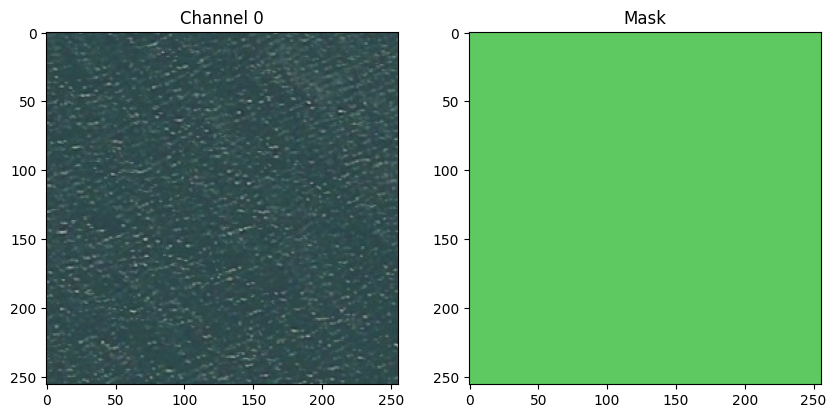

In [67]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


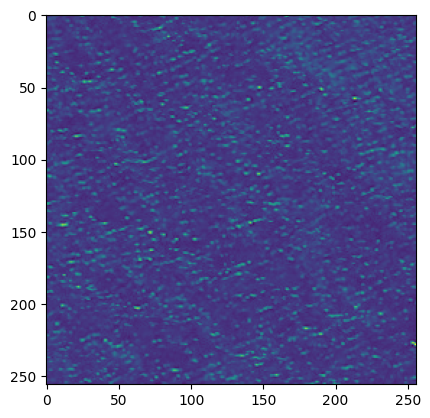

In [68]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






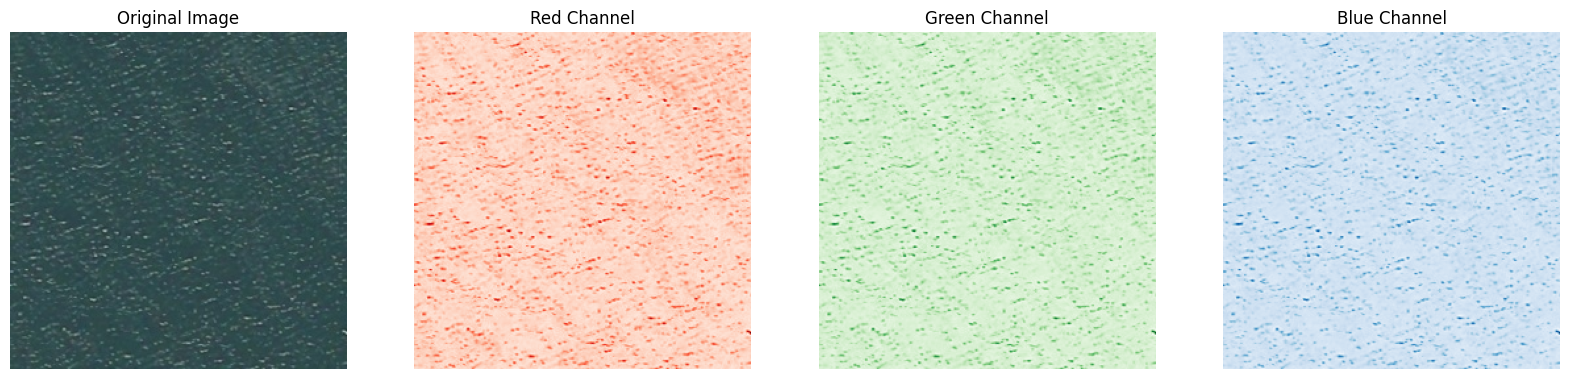

In [69]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [70]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 47  48  49  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 175 176
 177 178 180 189 203]  and the counts are:  [   1    1    1    1    2    2    5    4    5    9   13   12   24   35
   64   61   89  155  209  344  532  797 1219 1809 2516 3342 4201 4732
 5083 4961 4496 3999 3252 2751 2280 1947 1677 1359 1227 1139  982  818
  776  628  601  538  512  513  415  433  356  341  342  277  269  234
  211  194  188  151  147  155  141  163  124   94  106   97   89   93
   95   86   72   64   59   66   57   57   32   39   42   30   34   46
   30 

In [71]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 47  48  49  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 175 176
 177 178 180 189 203]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107


### Define Generator for images and masks

In [72]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [73]:
print(n_classes)

5


In [74]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [75]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [76]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [77]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x7915643cbba0>
<generator object trainGenerator at 0x7915643cb480>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


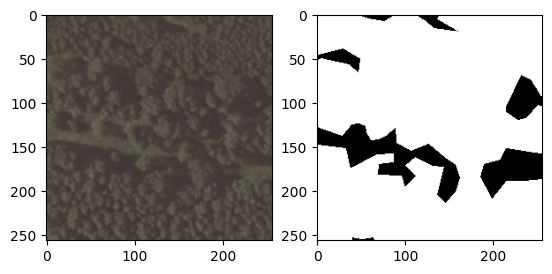

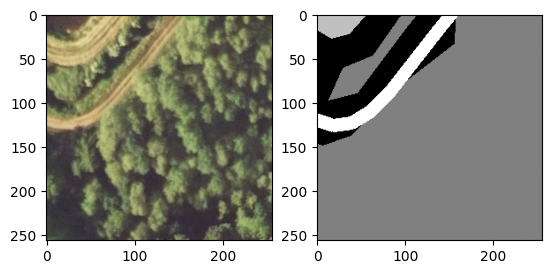

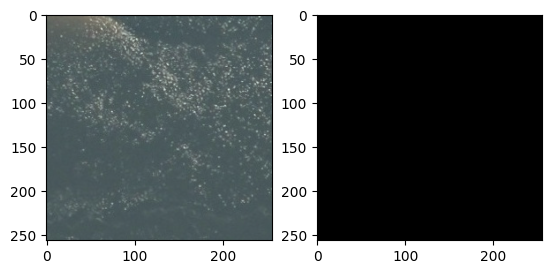

In [78]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


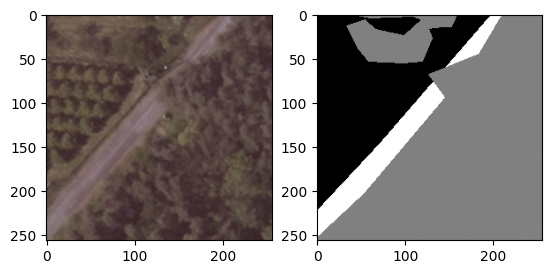

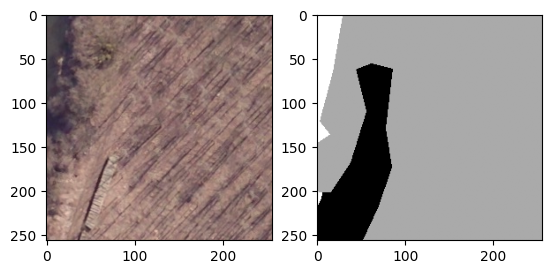

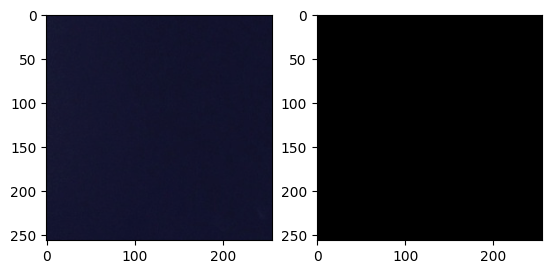

In [79]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [80]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 100

In [81]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [82]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_68   │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_69   │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_6… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_70   │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 32,561,694 (124.21 MB)

 Trainable params: 9,059,224 (34.56 MB)

 Non-trainable params: 23,502,470 (89.65 MB)

None
(None, 256, 256, 3)


In [83]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [84]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/100


2025-04-01 22:45:37.193226: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


140/140 ━━━━━━━━━━━━━━━━━━━━ 120s 538ms/step - custom_iou_score: 0.3397 - loss: 0.6934 - val_custom_iou_score: 0.0581 - val_loss: 1.0645
Epoch 2/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.5510 - loss: 0.4812 - val_custom_iou_score: 0.0743 - val_loss: 1.3087
Epoch 3/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - custom_iou_score: 0.5449 - loss: 0.4875

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.5953 - loss: 0.4351 - val_custom_iou_score: 0.0736 - val_loss: 1.3787
Epoch 4/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.6390 - loss: 0.3895 - val_custom_iou_score: 0.0748 - val_loss: 1.3685
Epoch 5/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.6608 - loss: 0.3640 - val_custom_iou_score: 0.1119 - val_loss: 1.1848
Epoch 6/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.6705 - loss: 0.3543 - val_custom_iou_score: 0.2974 - val_loss: 0.8769
Epoch 7/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.6793 - loss: 0.3459 - val_custom_iou_score: 0.3818 - val_loss: 0.7263
Epoch 8/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.6783 - loss: 0.3471 - val_custom_iou_score: 0.5920 - val_loss: 0.4474
Epoch 9/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7015 - loss: 0.3204 - val_custom_iou_score: 0.6596 - val_loss: 0.3704
Epoch 10/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.6925 - loss: 0.3299 - val_custom_iou_score: 0.5876 - val_loss: 0.4637
Epoch 11/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7186 - loss: 0.3030 - val_custom_iou_score: 0.6860 - val_loss: 0.3391
Epoch 12/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7147 - loss: 0.3071 - val_custom_iou_score: 0.6704 - val_loss: 0.3529
Epoch 13/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7155 - loss: 0.3058 - val_custom_iou_score: 0.6991 - val_loss: 0.3304
Epoch 14/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7286 - loss: 0.2915 - val_custom_iou_score: 0.6984 - val_loss: 0.3229
Epoch 15/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7252 - loss: 0.2958 - val_custom_iou_score: 0.7069 - val_loss: 0.3152
Epoch 16/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7249 - loss: 0.2957 - val_custom_iou_score: 0.7103 - val_loss: 0.3119
Epoch 17/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7256 - loss: 0.2939 - val_custom_iou_score: 0.7023 - val_loss: 0.3205
Epoch 18/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7453 - loss: 0.2739 - val_custom_iou_score: 0.7089 - val_loss: 0.3144
Epoch 19/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7395 - loss: 0.2815 - val_custom_iou_score: 0.7147 - val_loss: 0.3087
Epoch 20/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7431 - loss: 0.2763 - val_custom_iou_score: 0.7067 - val_loss: 0.3172
Epoch 21/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7426 - loss: 0.2776 - val_custom_iou_score: 0.7233 - val_loss: 0.2965
Epoch 22/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7480 - loss: 0.2705 - val_custom_iou_score: 0.7259 - val_loss: 0.2952
Epoch 23/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7529 - loss: 0.2665 - val_custom_iou_score: 0.7173 - val_loss: 0.3064
Epoch 24/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7289 - loss: 0.2907 - val_custom_iou_score: 0.7046 - val_loss: 0.3180
Epoch 25/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7599 - loss: 0.2580 - val_custom_iou_score: 0.7184 - val_loss: 0.3027
Epoch 26/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7524 - loss: 0.2661 - val_custom_iou_score: 0.7235 - val_loss: 0.3018
Epoch 27/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7592 - loss: 0.2578 - val_custom_iou_score: 0.7299 - val_loss: 0.2905
Epoch 28/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7483 - loss: 0.2691 - val_custom_iou_score: 0.7304 - val_loss: 0.2920
Epoch 29/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7588 - loss: 0.2590 - val_custom_iou_score: 0.7040 - val_loss: 0.3198
Epoch 30/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7532 - loss: 0.2658 - val_custom_iou_score: 0.7169 - val_loss: 0.3055
Epoch 31/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7741 - loss: 0.2439 - val_custom_iou_score: 0.7295 - val_loss: 0.2936
Epoch 32/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7575 - loss: 0.2596 - val_custom_iou_score: 0.7305 - val_loss: 0.2895
Epoch 33/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7653 - loss: 0.2525 - val_custom_iou_score: 0.7328 - val_loss: 0.2872
Epoch 34/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7657 - loss: 0.2523 - val_custom_iou_score: 0.7381 - val_loss: 0.2838
Epoch 35/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7736 - loss: 0.2427 - val_custom_iou_score: 0.7340 - val_loss: 0.2876
Epoch 36/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7705 - loss: 0.2465 - val_custom_iou_score: 0.7388 - val_loss: 0.2817
Epoch 37/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7754 - loss: 0.2419 - val_custom_iou_score: 0.7379 - val_loss: 0.2837
Epoch 38/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7813 - loss: 0.2362 - val_custom_iou_score: 0.7410 - val_loss: 0.2792
Epoch 39/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7710 - loss: 0.2459 - val_custom_iou_score: 0.7297 - val_loss: 0.2913
Epoch 40/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7774 - loss: 0.2388 - val_custom_iou_score: 0.7300 - val_loss: 0.2932
Epoch 41/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7793 - loss: 0.2374 - val_custom_iou_score: 0.7447 - val_loss: 0.2769
Epoch 42/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7745 - loss: 0.2425 - val_custom_iou_score: 0.7410 - val_loss: 0.2790
Epoch 43/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7821 - loss: 0.2332 - val_custom_iou_score: 0.7328 - val_loss: 0.2883
Epoch 44/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7865 - loss: 0.2296 - val_custom_iou_score: 0.7419 - val_loss: 0.2815
Epoch 45/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7875 - loss: 0.2290 - val_custom_iou_score: 0.7331 - val_loss: 0.2891
Epoch 46/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7745 - loss: 0.2423 - val_custom_iou_score: 0.7333 - val_loss: 0.2887
Epoch 47/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7863 - loss: 0.2310 - val_custom_iou_score: 0.7363 - val_loss: 0.2842
Epoch 48/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7818 - loss: 0.2342 - val_custom_iou_score: 0.7219 - val_loss: 0.3009
Epoch 49/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7888 - loss: 0.2270 - val_custom_iou_score: 0.7315 - val_loss: 0.2900
Epoch 50/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - custom_iou_score: 0.7896 - loss: 0.2271 - val_custom_iou_score: 0.7341 - val_loss: 0.2873
Epoch 51/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7990 - loss: 0.2160 - val_custom_iou_score: 0.7437 - val_loss: 0.2774
Epoch 52/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7951 - loss: 0.2199 - val_custom_iou_score: 0.7190 - val_loss: 0.3029
Epoch 53/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7838 - loss: 0.2315 - val_custom_iou_score: 0.7090 - val_loss: 0.3208
Epoch 54/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7893 - loss: 0.2253 - val_custom_iou_score: 0.7408 - val_loss: 0.2792
Epoch 55/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - custom_iou_score: 0.7887 - loss: 0.2268 - val_custom_iou_score: 0.7273 - val_loss: 0.2950
Epoch 56/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7984 - loss: 0.2171 - val_custom_iou_score: 0.7421 - val_loss: 0.2840
Epoch 57/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7982 - loss: 0.2174 - val_custom_iou_score: 0.7372 - val_loss: 0.2852
Epoch 58/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7853 - loss: 0.2307 - val_custom_iou_score: 0.7368 - val_loss: 0.2852
Epoch 59/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7919 - loss: 0.2235 - val_custom_iou_score: 0.7268 - val_loss: 0.2954
Epoch 60/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7986 - loss: 0.2168 - val_custom_iou_score: 0.7429 - val_loss: 0.2793
Epoch 61/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.7858 - loss: 0.2306 - val_custom_iou_score: 0.7315 - val_loss: 0.2918
Epoch 62/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - custom_iou_score: 0.8027 - loss: 0.2123 - val_custom_iou_score: 0.7443 - val_loss: 0.2774
Epoch 63/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8073 - loss: 0.2065 - val_custom_iou_score: 0.7373 - val_loss: 0.2837
Epoch 64/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8049 - loss: 0.2099 - val_custom_iou_score: 0.7323 - val_loss: 0.2900
Epoch 65/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8072 - loss: 0.2081 - val_custom_iou_score: 0.7239 - val_loss: 0.3014
Epoch 66/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8078 - loss: 0.2062 - val_custom_iou_score: 0.7499 - val_loss: 0.2698
Epoch 67/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8077 - loss: 0.2069 - val_custom_iou_score: 0.7184 - val_loss: 0.3038
Epoch 68/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.7919 - loss: 0.2249 - val_custom_iou_score: 0.7356 - val_loss: 0.2858
Epoch 69/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - custom_iou_score: 0.8038 - loss: 0.2105 - val_custom_iou_score: 0.7278 - val_loss: 0.2969
Epoch 70/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8162 - loss: 0.1976 - val_custom_iou_score: 0.7494 - val_loss: 0.2715
Epoch 71/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8125 - loss: 0.2020 - val_custom_iou_score: 0.7413 - val_loss: 0.2809
Epoch 72/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8137 - loss: 0.2003 - val_custom_iou_score: 0.7421 - val_loss: 0.2796
Epoch 73/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8225 - loss: 0.1912 - val_custom_iou_score: 0.7478 - val_loss: 0.2761
Epoch 74/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8198 - loss: 0.1944 - val_custom_iou_score: 0.6812 - val_loss: 0.3489
Epoch 75/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8021 - loss: 0.2124 - val_custom_iou_score: 0.7405 - val_loss: 0.2835
Epoch 76/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - custom_iou_score: 0.8121 - loss: 0.2017 - val_custom_iou_score: 0.7366 - val_loss: 0.2861
Epoch 77/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8106 - loss: 0.2039 - val_custom_iou_score: 0.7420 - val_loss: 0.2805
Epoch 78/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8162 - loss: 0.1977 - val_custom_iou_score: 0.7492 - val_loss: 0.2722
Epoch 79/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8221 - loss: 0.1912 - val_custom_iou_score: 0.7189 - val_loss: 0.3053
Epoch 80/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8022 - loss: 0.2131 - val_custom_iou_score: 0.7381 - val_loss: 0.2836
Epoch 81/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8148 - loss: 0.1991 - val_custom_iou_score: 0.7375 - val_loss: 0.2842
Epoch 82/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8195 - loss: 0.1937 - val_custom_iou_score: 0.7445 - val_loss: 0.2771
Epoch 83/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8134 - loss: 0.2005 - val_custom_iou_score: 0.7463 - val_loss: 0.2760
Epoch 84/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8217 - loss: 0.1924 - val_custom_iou_score: 0.7511 - val_loss: 0.2694
Epoch 85/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8180 - loss: 0.1952 - val_custom_iou_score: 0.7404 - val_loss: 0.2837
Epoch 86/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8028 - loss: 0.2124 - val_custom_iou_score: 0.7443 - val_loss: 0.2771
Epoch 87/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8193 - loss: 0.1948 - val_custom_iou_score: 0.7410 - val_loss: 0.2822
Epoch 88/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8215 - loss: 0.1920 - val_custom_iou_score: 0.7454 - val_loss: 0.2772
Epoch 89/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - custom_iou_score: 0.8244 - loss: 0.1890 - val_custom_iou_score: 0.7484 - val_loss: 0.2739
Epoch 90/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8254 - loss: 0.1874 - val_custom_iou_score: 0.7427 - val_loss: 0.2787
Epoch 91/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - custom_iou_score: 0.8238 - loss: 0.1892 - val_custom_iou_score: 0.7451 - val_loss: 0.2775
Epoch 92/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8192 - loss: 0.1942 - val_custom_iou_score: 0.7333 - val_loss: 0.2902
Epoch 93/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8191 - loss: 0.1945 - val_custom_iou_score: 0.7481 - val_loss: 0.2726
Epoch 94/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8260 - loss: 0.1872 - val_custom_iou_score: 0.7413 - val_loss: 0.2791
Epoch 95/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8235 - loss: 0.1894 - val_custom_iou_score: 0.7436 - val_loss: 0.2807
Epoch 96/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8198 - loss: 0.1954 - val_custom_iou_score: 0.7388 - val_loss: 0.2836
Epoch 97/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - custom_iou_score: 0.8367 - loss: 0.1762 - val_custom_iou_score: 0.7454 - val_loss: 0.2768
Epoch 98/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - custom_iou_score: 0.8311 - loss: 0.1817 - val_custom_iou_score: 0.7485 - val_loss: 0.2729
Epoch 99/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8298 - loss: 0.1826 - val_custom_iou_score: 0.7433 - val_loss: 0.2781
Epoch 100/100


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - custom_iou_score: 0.8421 - loss: 0.1698 - val_custom_iou_score: 0.7475 - val_loss: 0.2740


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

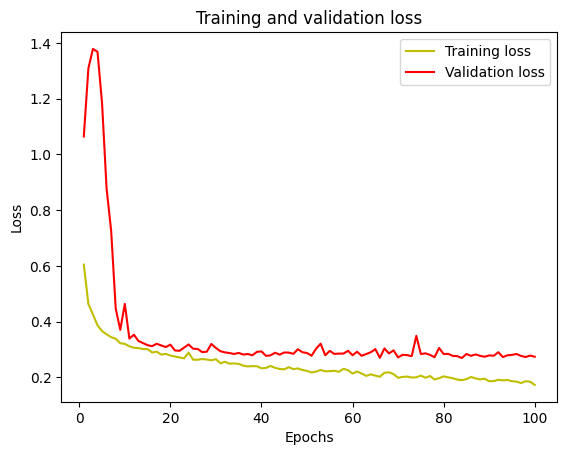

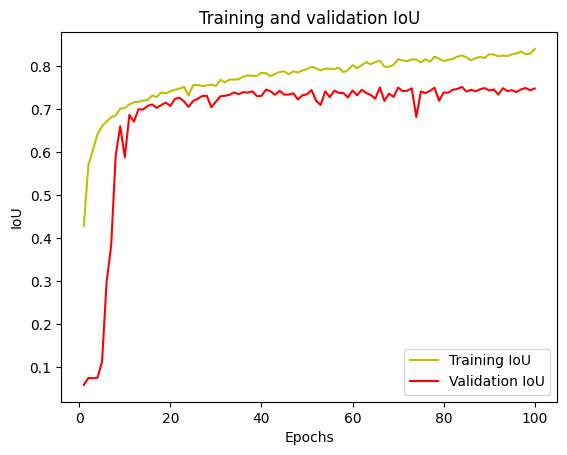

In [85]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

### Evaulate model on test data

In [86]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Mean IoU = 0.77336806


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [87]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.17274175584316254
Mean Squared Error: 0.5162925720214844
Accuracy: 0.9151973724365234
R-squared: 0.8036814499337206


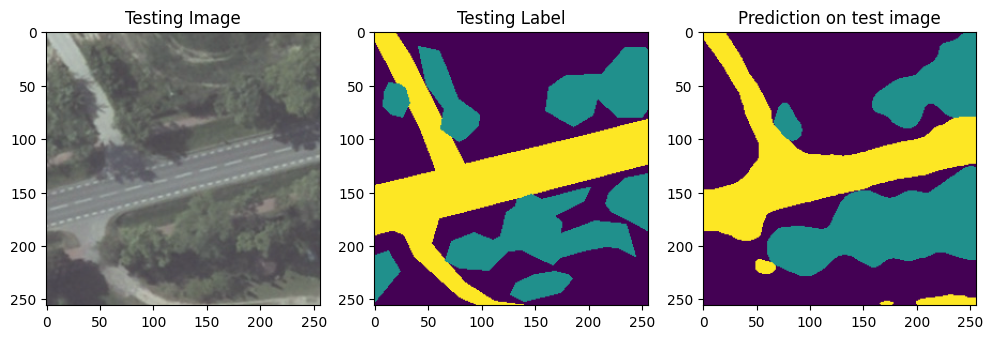

In [95]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()